# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Does it work?
  * Does the output as each stage look OK?

# Setting variables

In [ ]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

# Init

In [8]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [ ]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    

In [103]:
%%R
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

cat('Min BD:', min_range_BD, '\n')
cat('Max BD:', max_range_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Simulating fragments

In [11]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [13]:
!cd $workDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Number of amplicons per taxon

In [14]:
!cd $workDir; \
    grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 338|    o       
 320|    o       
 303|    o       
 285|    o       
 268|    o       
 250|    o       
 232|   oo       
 215|   oo       
 197|   oo       
 180|   oo       
 162|   oo o     
 144|   oo o     
 127|  ooo o     
 109|  ooo o     
  92|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1147     |
|    min value: 0.000000     |
|      mean : 3.823888       |
|    max value: 15.000000    |
------------------------------


In [16]:
!printf "Number of taxa with >=1 amplicon: "
!cd $workDir; \
    grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1102


# Converting fragments to kde object

In [17]:
!cd $workDir; \
    SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [18]:
!cd $workDir; \
    SIPSim KDE_info -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [19]:
%%R -i workDir -w 600 -h 300

# loading
inFile = file.path(workDir, 'ampFrags_kde_info.txt')
df = read.delim(inFile, sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

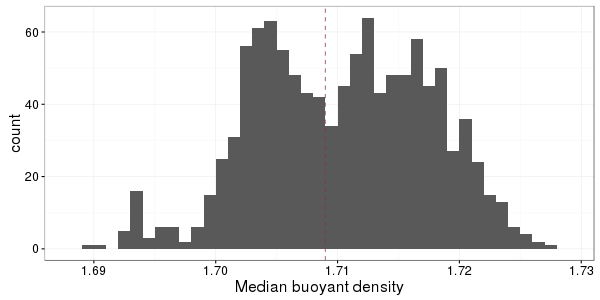

In [20]:
%%R -w 600 -h 300
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Adding diffusion

In [21]:
!cd $workDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'contamination'

* DBL = diffusive boundary layer

In [22]:
!cd $workDir; \
    SIPSim DBL \
    ampFrags_kde_dif.pkl \
    --np 24 \
    > ampFrags_kde_dif_DBL.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!cd $workDir; \
    tail ampFrags_kde_dif_DBL.log

Processing: Kosakonia_sacchari_SP1
Processing: Dictyoglomus_thermophilum_H-6-12
Processing: Gluconobacter_oxydans_621H
Processing: Oscillatoria_acuminata_PCC_6304
Processing: Nocardia_farcinica_IFM_10152
Processing: Ruminococcus_albus_7_DSM_20455
Processing: Campylobacter_ureolyticus_RIGS_9880
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Dyadobacter_fermentans_DSM_18053
Processing: Mycobacterium_africanum_GM041182


## Comparing DBL+diffusion to diffusion

In [23]:
# none
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!cd $workDir; \
    SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [24]:
%%R -i workDir

inFile = file.path(workDir, 'ampFrags_kde_info.txt')
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'raw'

inFile = file.path(workDir, 'ampFrags_kde_dif_info.txt')
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'
inFile = file.path(workDir, 'ampFrags_kde_dif_DBL_info.txt')
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

                       taxon_ID KDE_ID        min percentile_5 percentile_25
1 Tropheryma_whipplei_str_Twist      1   1.706466     1.707317       1.70827
2 Tropheryma_whipplei_str_Twist      2 377.000000  4092.950000    6118.75000
3   Caldisericum_exile_AZM16c01    NaN        NaN          NaN           NaN
        mean      median percentile_75 percentile_95          max        stdev
1    1.70971    1.709829      1.710692      1.712587     1.718228 1.616180e-03
2 7039.45050 7310.500000   8204.250000   9071.000000 10298.000000 1.538438e+03
3        NaN         NaN           NaN           NaN          NaN          NaN
  stage
1   raw
2   raw
3   raw


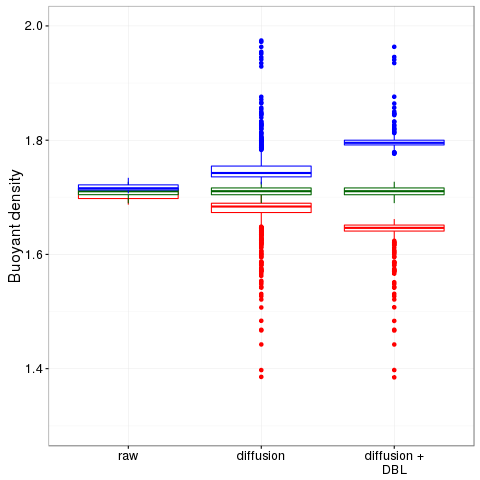

In [25]:
%%R

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Creating a community file

In [26]:
!cd $workDir; \
    SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

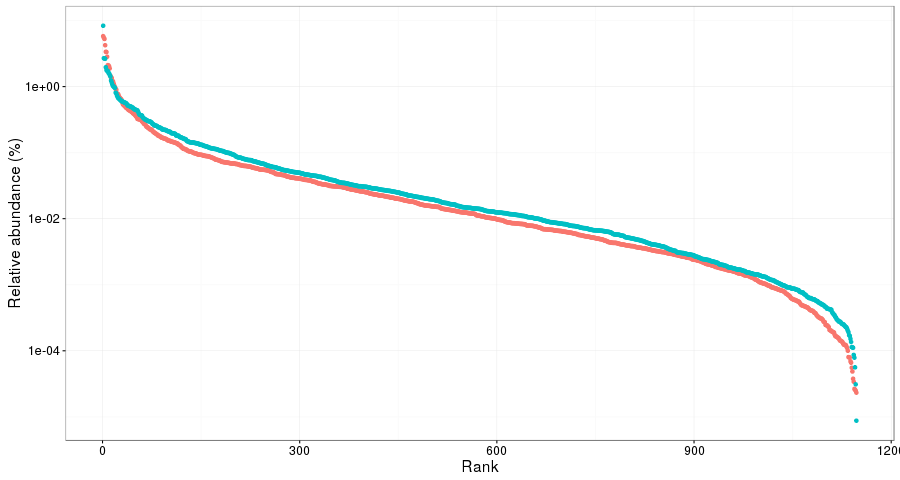

In [27]:
%%R -w 900 -i workDir

setwd(workDir)

tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        legend.position='none'
        )

#### Notes:

* Colors = pre-fractionation communities

# Making an incorp config file

In [28]:
!cd $workDir; \
    SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config
    
# checking output
!cd $workDir; \
    head PT10_PI100.config


[1]
    # baseline: no incorporation
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            
            [[[[interPopDist 1]]]]


# Adding isotope incorporation to BD distribution

In [ ]:
!cd $workDir; \
    SIPSim isotope_incorp \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    --comm comm.txt \
    --np 24 \
    > ampFrags_kde_dif_DBL_incorp.pkl \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking lag
!cd $workDir; \
    tail ampFrags_kde_dif_DBL_incorp.log

Processing: Desulfurispirillum_indicum_S5
Processing: Thermocrinis_albus_DSM_14484
Processing: Emticicia_oligotrophica_DSM_17448
Processing: Mesorhizobium_ciceri_biovar_biserrulae_WSM1271
Processing: Methylacidiphilum_infernorum_V4
Processing: Helicobacter_acinonychis_str_Sheeba
Processing: Rickettsia_montanensis_str_OSU_85-930
Processing: Streptomyces_hygroscopicus_subsp_limoneus
Processing: Bordetella_bronchiseptica_MO149
Processing: Mesorhizobium_opportunistum_WSM2075


# Calculating BD shift from isotope incorporation

In [ ]:
!cd $workDir; \
    SIPSim BD_shift \
    ampFrags_kde_dif_DBL.pkl \
    ampFrags_kde_dif_DBL_incorp.pkl \
    --np 30 \
    > ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    2> ampFrags_kde_dif_DBL_incorp_BD-shift.log
    
# checking log
!cd $workDir; \
    tail ampFrags_kde_dif_DBL_incorp_BD-shift.log

## Plotting BD-shift

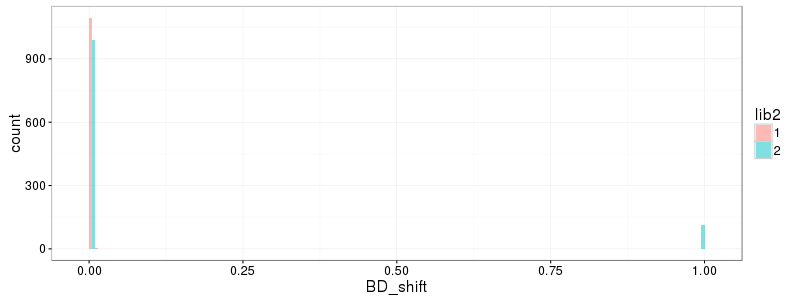

In [88]:
%%R -i workDir -w 800 -h 300

inFile = file.path(workDir, 'ampFrags_kde_dif_DBL_incorp_BD-shift.txt')

tbl = read.csv(inFile, sep='\t')

tbl$lib2 = as.character(tbl$lib2)
ggplot(tbl, aes(BD_shift, fill=lib2)) +
    geom_histogram(position='dodge', alpha=0.5, binwidth=0.01) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

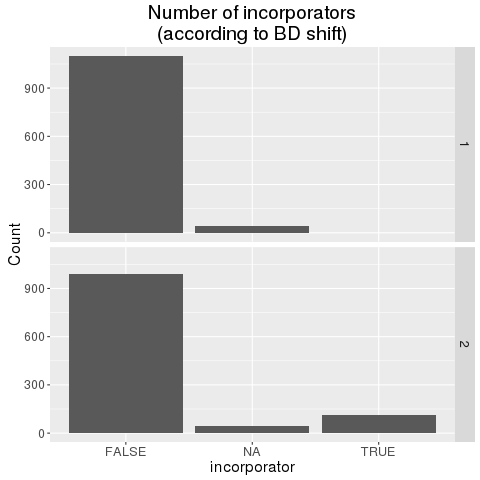

In [89]:
%%R

tbl.s = tbl %>% 
    mutate(incorporator = ifelse(BD_shift > 0.05, TRUE, FALSE)) %>%
    mutate(incorporator = ifelse(is.na(incorporator), 'NA', incorporator)) %>%
    group_by(lib2, incorporator) %>%
    summarize(n_incorps = n())

ggplot(tbl.s, aes(incorporator, n_incorps)) +
    geom_bar(stat='identity') +
    labs(y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    facet_grid(lib2 ~ .) +
    theme(
        text = element_text(size=16)
    )

# Simulating gradient fractions

In [ ]:
!cd $workDir; \
    SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt    

## Plotting fractions

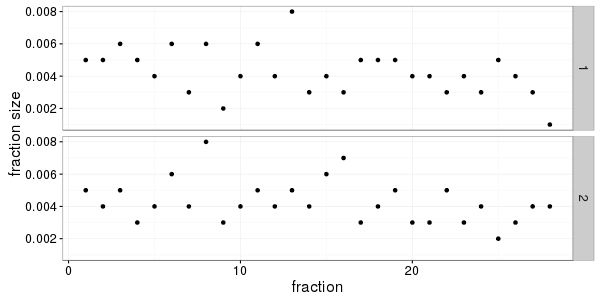

In [90]:
%%R -i workDir -w 600 -h 300
setwd(workDir)

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_point() +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

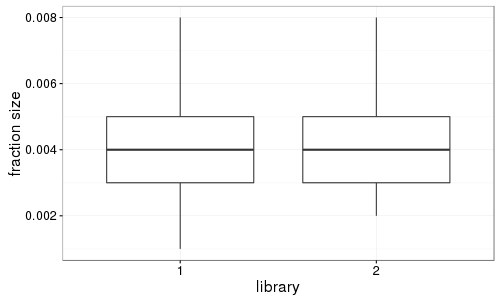

In [91]:
%%R -w 500 -h 300
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating an OTU table

In [ ]:
!cd $workDir; \
    SIPSim OTU_table \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np 24 \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!cd $workDir; \
    tail OTU_n2_abs1e9.log 

## Plotting taxon abundances

In [152]:
%%R -i workDir

inFile = file.path(workDir, 'OTU_n2_abs1e9.txt')

# loading file
df = read.delim(inFile, sep='\t') %>%
     filter(BD_mid >= min_range_BD,
            BD_mid <= max_range_BD) 

In [153]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

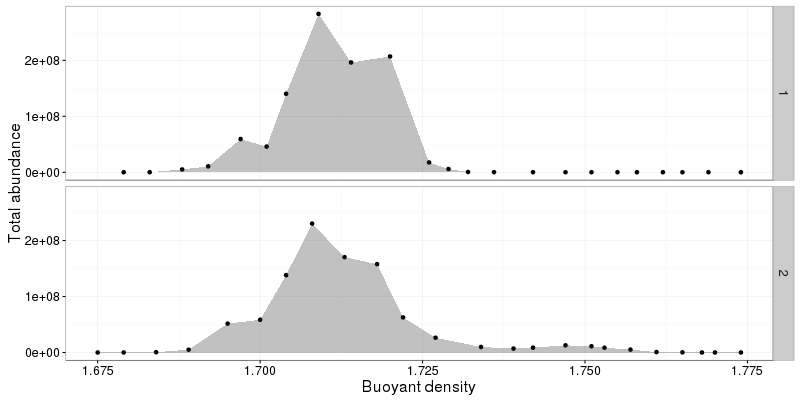

In [154]:
%%R -w 800 -h 400
# plotting absolute abundances

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

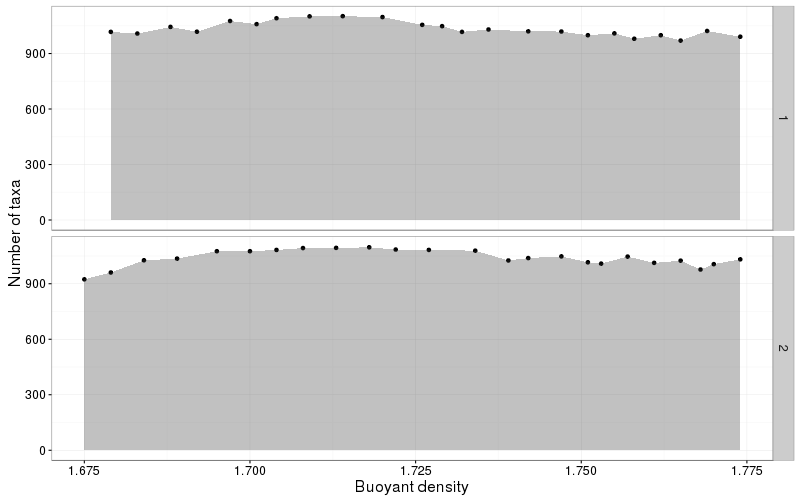

In [155]:
%%R -w 800 -h 500
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    #geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

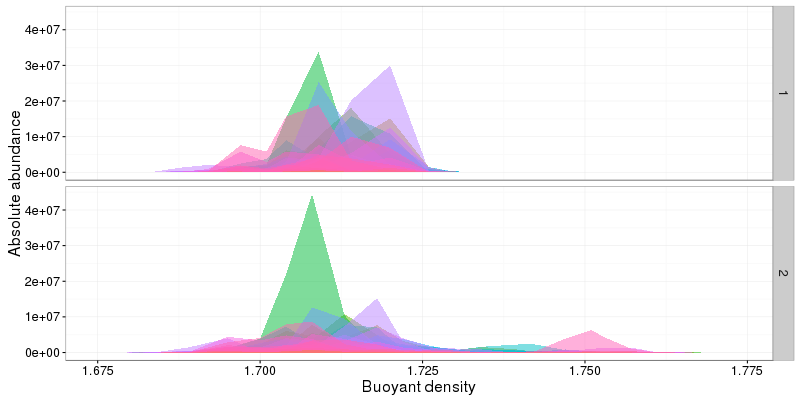

In [156]:
%%R -w 800 -h 400
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    #geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

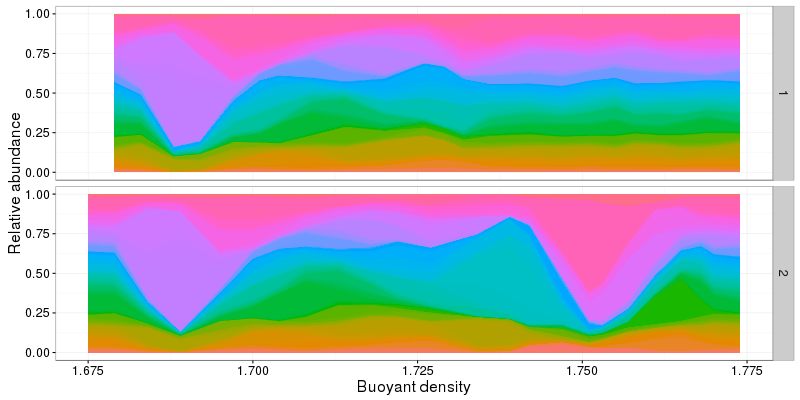

In [157]:
%%R -w 800 -h 400
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

## Plotting shannon diversity

In [158]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

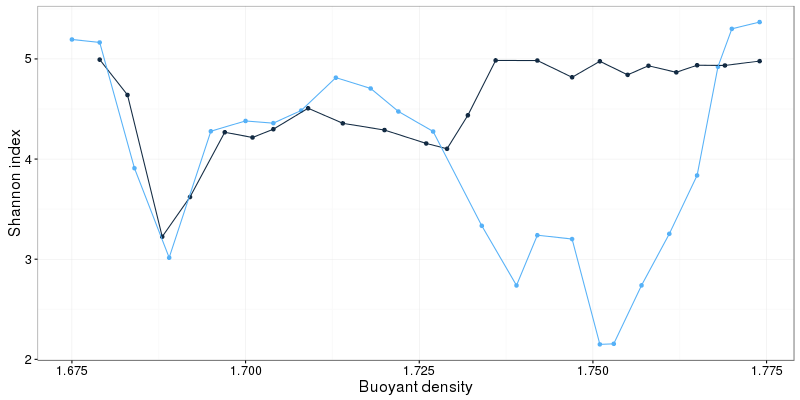

In [159]:
%%R -w 800 -h 400

# calculating shannon
df.shan = shannon_index_long(df, 'count', 'library', 'fraction')

## plot
p = ggplot(df.shan, aes(BD_mid, shannon, color=library, group=library)) +
    geom_point() +
    geom_line() +
    #geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

## OTU BD range

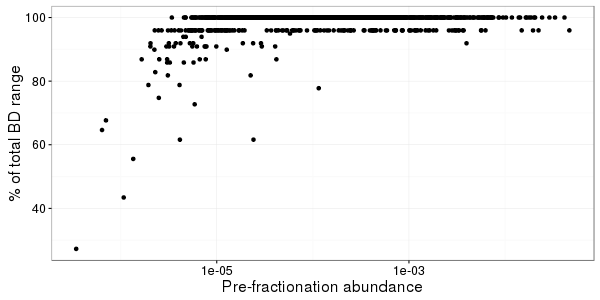

In [160]:
%%R -w 600 -h 300

max_BD_range = max(df$BD_mid) - min(df$BD_mid)

df.r = df %>%
    filter(count > 0) %>%
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(rel_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() 

# plotting
ggplot(df.r, aes(mean_rel_abund, BD_range_perc, group=taxon)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
    

# Simulating PCR bias

In [ ]:
!cd $workDir; \
    SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

In [ ]:
%%R -w 500 -h 450
# loading file
F = file.path(workDir, 'OTU_n2_abs1e9_PCR.txt')
df.SIM = read.delim(F, sep='\t')

ggplot(df.SIM, aes(init_molarity, final_molarity)) +
    geom_point() +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [ ]:
!cd $workDir; \
    SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:30000,scale:5000 \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_subNorm.txt

### Plotting seq count distribution

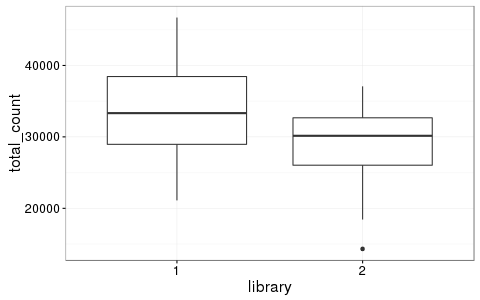

In [161]:
%%R -h 300
setwd(workDir)

df = read.csv('OTU_n2_abs1e9_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions (paper figure)

In [162]:
%%R -i workDir

setwd(workDir)

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

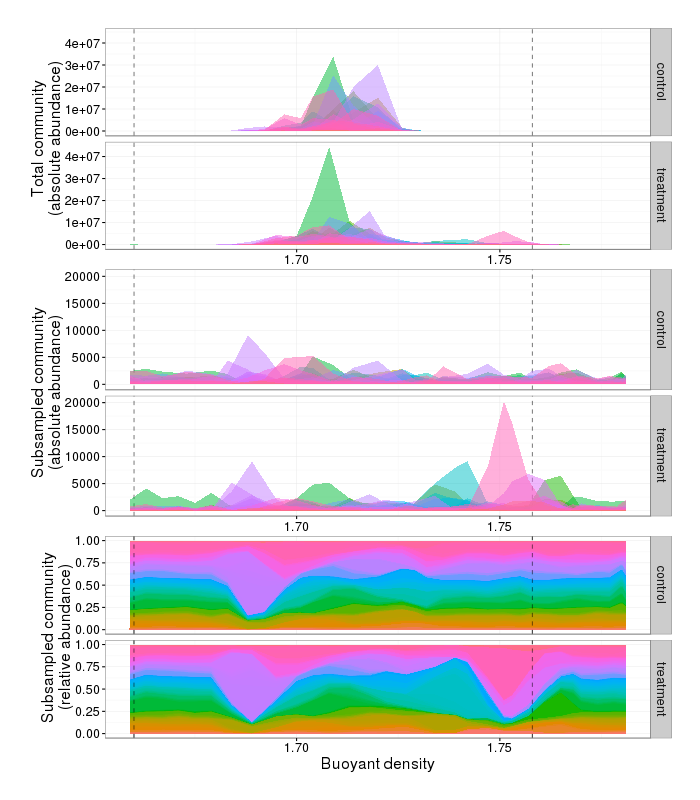

In [163]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

In [164]:
%%R -i figureDir 
# saving figure

outFile = paste(c(figureDir, 'abundDist_example.pdf'), collapse='/')

pdf(outFile, width=10.5, height=12)
grid.arrange(p1, p2, p3, ncol=1)
dev.off()

png 
  2 


# Making a wide OTU table

In [183]:
!cd $workDir; \
    SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [184]:
!cd $workDir; \
    SIPSim OTU_sampleData \
    OTU_n2_abs1e9_subNorm.txt \
    > OTU_n2_abs1e9_subNorm_meta.txt

# Community analysis

## Phyloseq

In [185]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs1e9_subNorm_w.txt \
    -s OTU_n2_abs1e9_subNorm_meta.txt \
    > OTU_n2_abs1e9_subNorm.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm.physeq \
    OTU_n2_abs1e9_subNorm_bray-NMDS.pdf    
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs1e9_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_subNorm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf
    
convert OTU_n2_abs1e9_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_bray-NMDS.png
convert OTU_n2_abs1e9_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1093698 
Run 1 stress 0.1094156 
... procrustes: rmse 0.005371973  max resid 0.03934507 
Run 2 stress 0.1173655 
Run 3 stress 0.1396424 
Run 4 stress 0.1694666 
Run 5 stress 0.1147503 
Run 6 stress 0.1658164 
Run 7 stress 0.1276991 
Run 8 stress 0.118415 
Run 9 stress 0.124991 
Run 10 stress 0.1097647 
... procrustes: rmse 0.03468466  max resid 0.1662433 
Run 11 stress 0.1162101 
Run 12 stress 0.1505217 
Run 13 stress 0.1776271 
Run 14 stress 0.1608501 
Run 15 stress 0.1810119 
Run 16 stress 0.1068164 
... New best solution
... procrustes: rmse 0.03212852  max resid 0.1648054 
Run 17 stress 0.1067975 
... New best solution
... procrustes: rmse 0.001433596  max resid 0.0107698 
Run 18 stress 0.1492991 
Run 19 stress 0.1159704 
Run 20 stress 0.1463549 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.06671758 
Run 1 stress 0.06671721 
... New best solution
... procrustes: rmse 0.000195990

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 


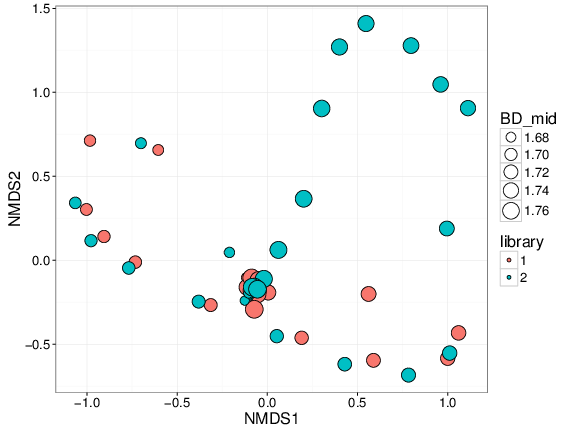

In [186]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_bray-NMDS.png') 

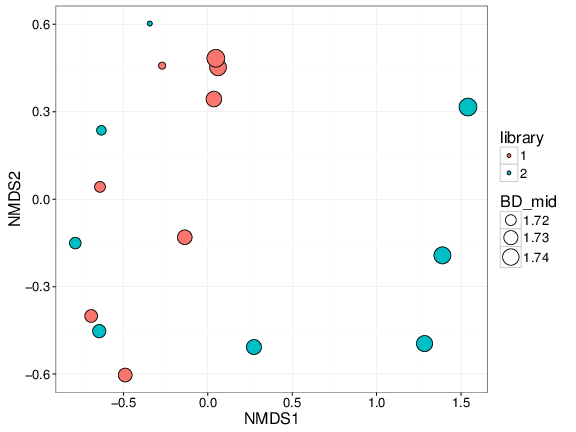

In [187]:
os.chdir(workDir)
Image(filename='OTU_n2_abs1e9_subNorm_filt_bray-NMDS.png')

## DESeq2

In [188]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# Chuck's method

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    > OTU_n2_abs1e9_subNorm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padjBH 0.1

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 45 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass

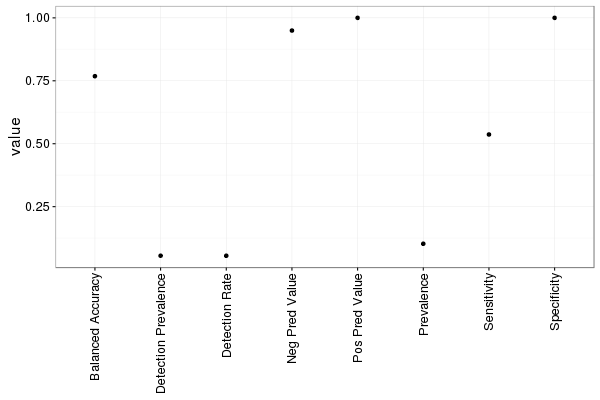

In [189]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

In [190]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# altHypothesis = 'greater'

## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs1e9_subNorm_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e9_subNorm_DESeq2
    
## Confusion matrix
DESeq2_confuseMtx.r \
    ampFrags_kde_dif_DBL_incorp_BD-shift.txt \
    OTU_n2_abs1e9_subNorm_DESeq2 \
    --padj 0.1    

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 45 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx_data.csv
File written: DESeq2-cMtx
File written: DESeq2-cMtx_table.csv
File written: DESeq2-cMtx_overall.csv
File written: DESeq2-cMtx_byClass

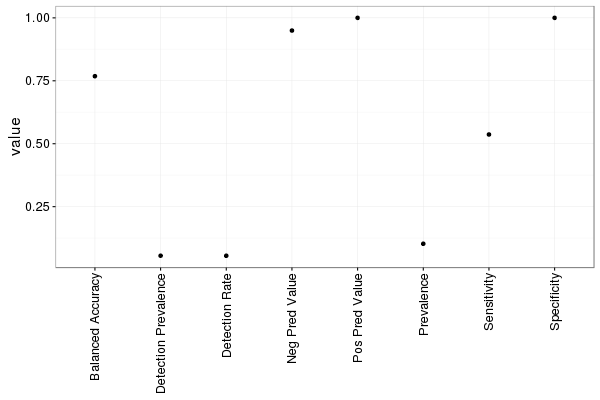

In [191]:
%%R -i workDir -w 600 -h 400

setwd(workDir)

byClass = read.csv('DESeq2-cMtx_byClass.csv')

ggplot(byClass, aes(X, byClass)) +
    geom_point() +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )

# Conclusions


* BD_shift and OTU_table are memory intensive & must use less cores
* DESeq2 sensitivity is low, but specificity is perfect

## Plotting results of DESeq2

In [192]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [193]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df = read.csv('DESeq2-cMtx_data.csv')

df = df %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  lib1 lib2                         taxon BD_shift     baseMean log2FoldChange
1   NA    2 Tropheryma_whipplei_str_Twist 0.996342  60.14293367      5.9111397
2   NA    2 Sorangium_cellulosum_So0157-2 0.000000 183.52356790     -1.5094403
3   NA    2       Bacillus_subtilis_QB928 0.000000   0.03407837     -0.6182483
     lfcSE     stat       pvalue        padj            p     padj.BH
1 1.471734 3.846578 5.988947e-05 0.001535499 5.988947e-05 0.001535499
2 1.233689 0.000000 9.230891e-01 0.999999657 9.230891e-01 0.999999657
3 2.296852 0.000000 6.472909e-01 0.999999657 6.472909e-01 0.999999657
  incorp.known incorp.pred           cls
1         TRUE        TRUE True positive
2        FALSE       FALSE True negative
3        FALSE       FALSE True negative


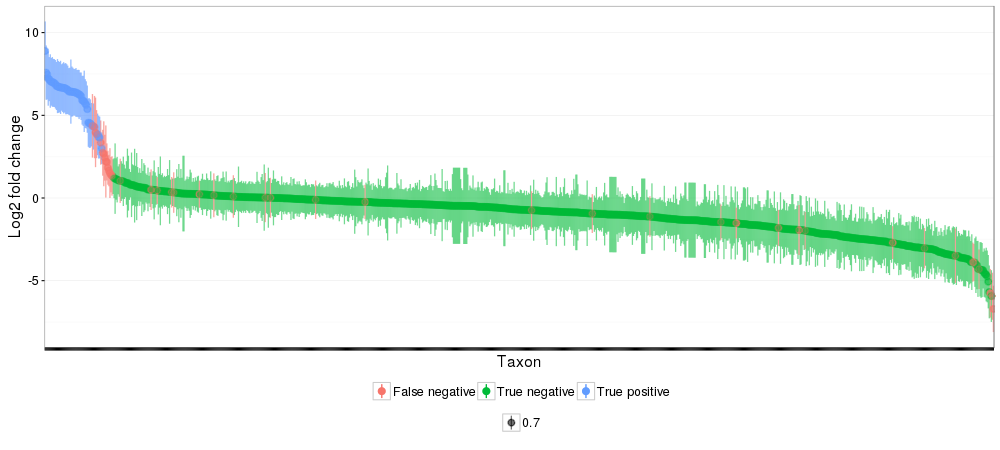

In [194]:
%%R -w 1000 -h 450

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, alpha=0.7,
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.6) +
    geom_pointrange(data=df.TP, size=0.6, alpha=0.2) +
    geom_pointrange(data=df.FP, size=0.6, alpha=0.2) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )

In [195]:
%%R -i figureDir

outFile = paste(c(figureDir, 'l2fc_example.pdf'), collapse='/')
ggsave(outFile, width=10, height=4.5)

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75
* Lines indicate standard errors.

# sensitivity ~ relative_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [196]:
%%R -i workDir

setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
df.otu = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t') %>%
    filter(BD_min >= 1.71, BD_max <= 1.75) %>%
    group_by(library, taxon) %>%
    mutate(min_rel_abund = min(rel_abund),
           mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    distinct(library, taxon) 

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))
df.j %>% head(n=3) %>% as.data.frame

  library    fraction                                taxon BD_min BD_mid BD_max
1       2 1.711-1.715       Acaryochloris_marina_MBIC11017  1.711  1.713  1.715
2       1 1.712-1.716       Acaryochloris_marina_MBIC11017  1.712  1.714  1.716
3       2 1.711-1.715 Acetobacter_pasteurianus_IFO_3283-03  1.711  1.713  1.715
  count    rel_abund min_rel_abund mean_rel_abund lib1 lib2  BD_shift
1     0 0.0000000000             0   0.0079945366   NA    2 0.9964645
2     5 0.0001746847             0   0.0002163414   NA    2 0.9964645
3    32 0.0008630222             0   0.0001362784   NA    2 0.0000000
    baseMean log2FoldChange    lfcSE     stat       pvalue         padj
1 260.611669       6.378762 1.477885 4.146982 1.684431e-05 0.0005671577
2 260.611669       6.378762 1.477885 4.146982 1.684431e-05 0.0005671577
3   2.597182      -0.861212 1.071837 0.000000 8.500705e-01 0.9999996566
             p      padj.BH incorp.known incorp.pred
1 1.684431e-05 0.0005671577         TRUE        TRUE
2 1.68

In [197]:
%%R
# classifying
df.j.f = df.j %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) %>%
    filter(cls != 'True negative')

In [198]:
%%R
df.L1 = df.j.f %>% filter(library == 1) %>%
    dplyr::select(taxon, min_rel_abund, mean_rel_abund, log2FoldChange, cls) #%>%
#    rename('lib1_mean_rel_abund' = mean_rel_abund)
df.L2 = df.j.f %>% filter(library == 2) %>%
    dplyr::select(taxon, min_rel_abund, mean_rel_abund, log2FoldChange, cls) #%>%
#    rename('lib2_mean_rel_abund' = mean_rel_abund)
df.j = inner_join(df.L1, df.L2, c('taxon' = 'taxon'))

df.j %>% head(n=3) %>% as.data.frame

                              taxon min_rel_abund.x mean_rel_abund.x
1    Acaryochloris_marina_MBIC11017               0     0.0002163414
2    Achromobacter_xylosoxidans_C54               0     0.0006719462
3 Advenella_mimigardefordensis_DPN7               0     0.0001435825
  log2FoldChange.x          cls.x min_rel_abund.y mean_rel_abund.y
1         6.378762  True positive               0      0.007994537
2         1.661448 False negative               0      0.003058823
3         5.876271  True positive               0      0.003729017
  log2FoldChange.y          cls.y
1         6.378762  True positive
2         1.661448 False negative
3         5.876271  True positive


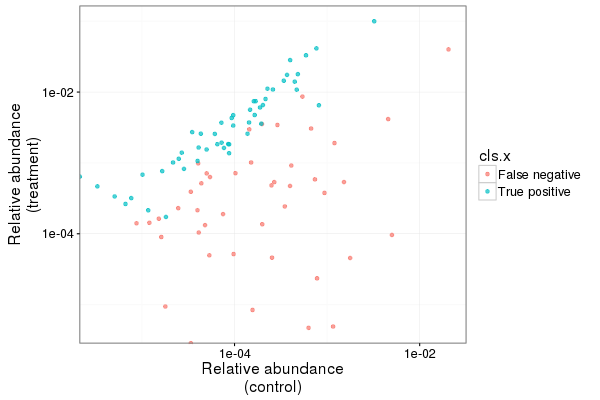

In [199]:
%%R -w 600 -h 400

ggplot(df.j, aes(mean_rel_abund.x, mean_rel_abund.y, color=cls.x)) +
    geom_point(alpha=0.7) +
    #geom_density2d() +
    scale_x_log10() +
    scale_y_log10() +
    labs(x = 'Relative abundance\n(control)', y='Relative abundance\n(treatment)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

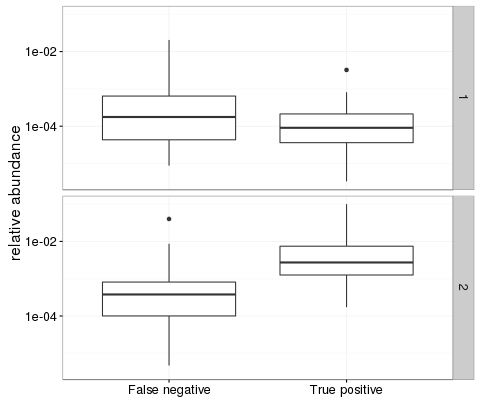

In [200]:
%%R -h 400
ggplot(df.j.f, aes(cls, mean_rel_abund)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y='relative abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

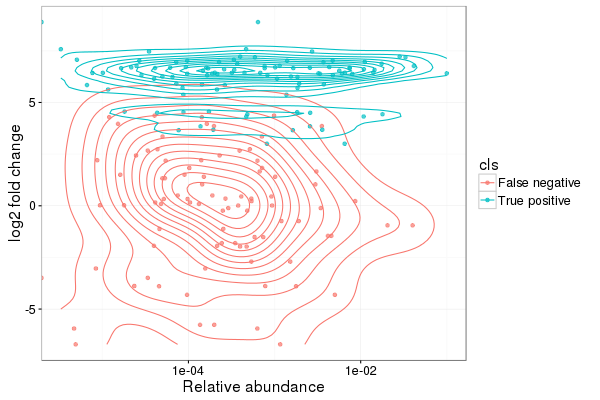

In [201]:
%%R -w 600 -h 400

ggplot(df.j.f, aes(mean_rel_abund, log2FoldChange, color=cls)) +
    geom_point(alpha=0.7) +
    geom_density2d() +
    scale_x_log10() +
    labs(x = 'Relative abundance', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes:

* More false negatives with lower relative abundance in the BD window

### biserial correlation

In [202]:
%%R
library(ltm)

levs = c('True positive', 'False negative')

df.j.f %>%
    mutate(cls = factor(cls, levels=levs)) %>%
    group_by(library) %>%
    summarize(biserial_cor = biserial.cor(mean_rel_abund, cls))

Source: local data frame [2 x 2]

  library biserial_cor
    (int)        (dbl)
1       1   -0.1745948
2       2    0.2479693


### t-test

In [203]:
%%R
t.test(mean_rel_abund ~ cls, data=df.j.f)


	Welch Two Sample t-test

data:  mean_rel_abund by cls
t = -2.1514, df = 139.17, p-value = 0.03317
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0052300352 -0.0002207463
sample estimates:
mean in group False negative  mean in group True positive 
                 0.001394445                  0.004119836 



# sensitivity ~ pre-frac_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [204]:
%%R -i workDir

setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

df.comm = read.delim('comm.txt', sep='\t') %>%
    mutate(rel_abund_perc = rel_abund_perc / 100) %>%
    rename('preFrac_rel_abund' = rel_abund_perc) 

df.j = inner_join(df.ds, df.comm, c('taxon' = 'taxon_name'))
df.j %>% head(n=3)

  lib1 lib2                         taxon BD_shift  baseMean log2FoldChange
1   NA    2 Tropheryma_whipplei_str_Twist 0.996342  60.14293        5.91114
2   NA    2 Tropheryma_whipplei_str_Twist 0.996342  60.14293        5.91114
3   NA    2 Sorangium_cellulosum_So0157-2 0.000000 183.52357       -1.50944
     lfcSE     stat       pvalue        padj            p     padj.BH
1 1.471734 3.846578 5.988947e-05 0.001535499 5.988947e-05 0.001535499
2 1.471734 3.846578 5.988947e-05 0.001535499 5.988947e-05 0.001535499
3 1.233689 0.000000 9.230891e-01 0.999999657 9.230891e-01 0.999999657
  incorp.known incorp.pred library preFrac_rel_abund rank
1         TRUE        TRUE       1      0.0001430435  516
2         TRUE        TRUE       2      0.0001773906  516
3        FALSE       FALSE       1      0.0006729435  205


In [205]:
%%R
# classifying
df.j.f = df.j %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) %>%
    filter(cls != 'True negative',
           library == 2)
df.j.f %>% head(n=3)

  lib1 lib2                           taxon  BD_shift   baseMean log2FoldChange
1   NA    2   Tropheryma_whipplei_str_Twist 0.9963420  60.142934       5.911140
2   NA    2 Mycobacterium_vanbaalenii_PYR-1 0.9966548   3.912576      -1.118131
3   NA    2    Helicobacter_cinaedi_PAGU611 0.9965798 258.446745       6.686730
     lfcSE     stat       pvalue         padj            p      padj.BH
1 1.471734 3.846578 5.988947e-05 0.0015354994 5.988947e-05 0.0015354994
2 1.221859 0.000000 8.685818e-01 0.9999996566 8.685818e-01 0.9999996566
3 1.608126 4.002628 3.132143e-05 0.0008502846 3.132143e-05 0.0008502846
  incorp.known incorp.pred library preFrac_rel_abund rank            cls
1         TRUE        TRUE       2      0.0001773906  516  True positive
2         TRUE       FALSE       2      0.0001396811  575 False negative
3         TRUE        TRUE       2      0.0005371765  279  True positive


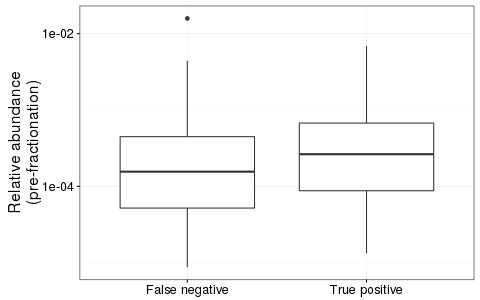

In [206]:
%%R -h 300

ggplot(df.j.f, aes(cls, preFrac_rel_abund)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y='Relative abundance\n(pre-fractionation)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

#### Notes:

* pre-fractionation abundance does matter for sensitivity

# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [207]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
df.otu = read.delim('OTU_n2_abs1e9_subNorm.txt', sep='\t')
#df.otu = read.delim('OTU_n2_abs1e9.txt', sep='\t')

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))

# edit
lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.j = mutate(df.j, library = plyr::revalue(as.character(library), lib.reval))

df.j %>% head(n=3)

    library    fraction                          taxon BD_min BD_mid BD_max
1   control  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
2 treatment  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
3   control 1.660-1.665 Acaryochloris_marina_MBIC11017   1.66  1.663  1.665
  count    rel_abund lib1 lib2  BD_shift baseMean log2FoldChange    lfcSE
1    29 0.0007482133   NA    2 0.9964645 260.6117       6.378762 1.477885
2     0 0.0000000000   NA    2 0.9964645 260.6117       6.378762 1.477885
3    19 0.0005993313   NA    2 0.9964645 260.6117       6.378762 1.477885
      stat       pvalue         padj            p      padj.BH incorp.known
1 4.146982 1.684431e-05 0.0005671577 1.684431e-05 0.0005671577         TRUE
2 4.146982 1.684431e-05 0.0005671577 1.684431e-05 0.0005671577         TRUE
3 4.146982 1.684431e-05 0.0005671577 1.684431e-05 0.0005671577         TRUE
  incorp.pred
1        TRUE
2        TRUE
3        TRUE


In [208]:
%%R
# DESeq2 params
BD.win.min = 1.71
BD.win.max = 1.75

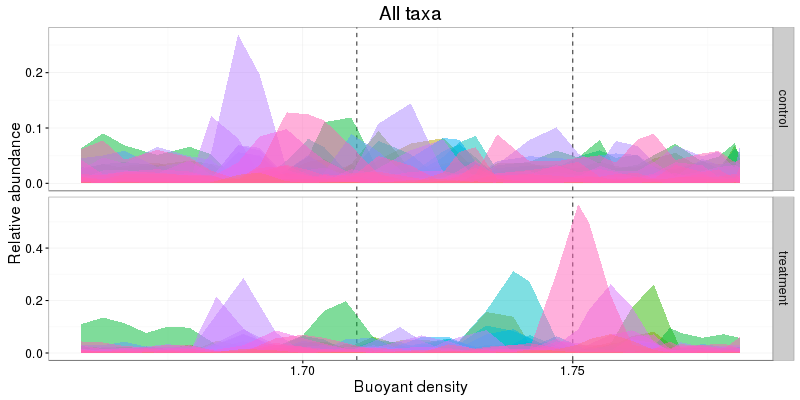

In [209]:
%%R -w 800 -h 400
# plotting relative abundances: all
## plot
p = ggplot(df.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='All taxa') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p

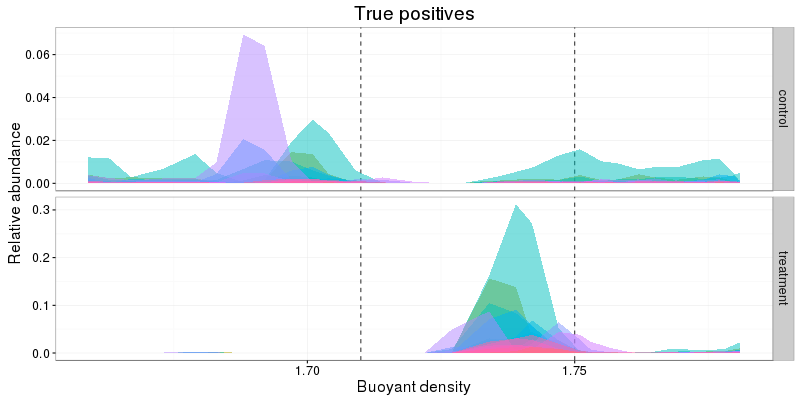

In [210]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.TP = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(df.j.TP, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='True positives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p1

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

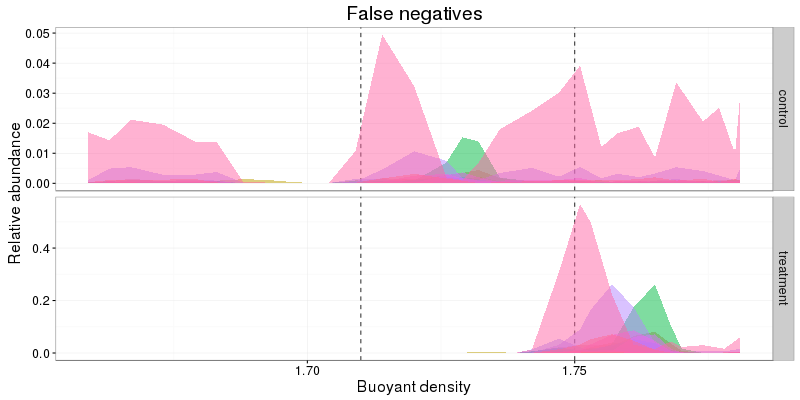

In [211]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.FN = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(df.j.FN, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='False negatives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p2

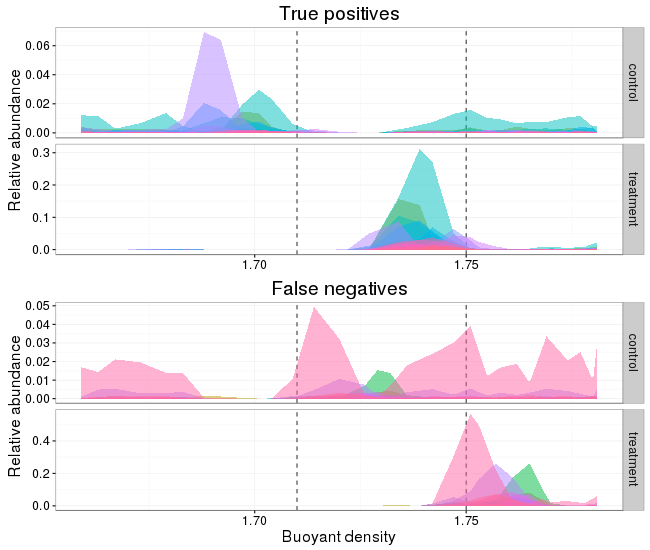

In [212]:
%%R -i figureDir -h 550 -w 650

outFile = paste(c(figureDir, 'abundDist_TP-FN_example.pdf'), collapse='/')

p1.e = p1 + theme(axis.title.x = element_blank())

pdf(outFile, width=13, height=11)
grid.arrange(p1.e, p2, ncol=1)
dev.off()

grid.arrange(p1.e, p2, ncol=1)

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

## Indy taxa BD shift plots

In [213]:
%%R
# checking on number of incorporators
df.j %>% filter(BD_shift > 0.05) %>% distinct(taxon) %>% nrow %>% print
df.j %>% filter(incorp.known == TRUE) %>% distinct(taxon) %>% nrow %>% print

[1] 95
[1] 95


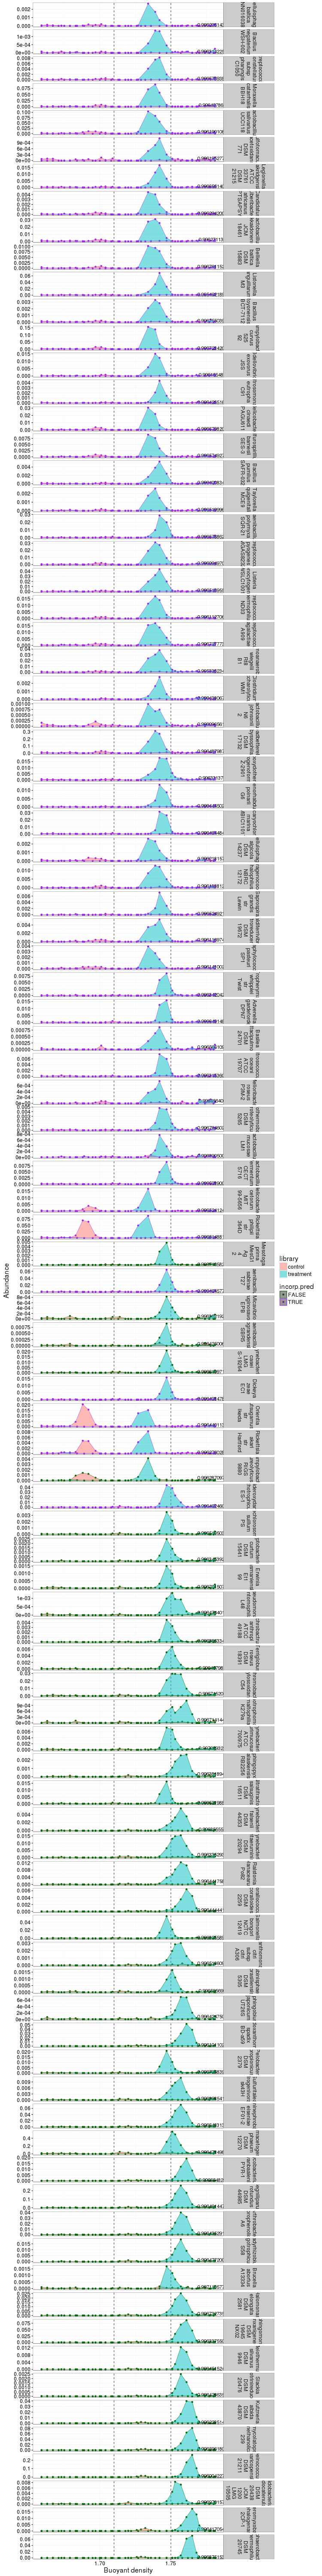

In [215]:
%%R -w 750 -h 6000
# plotting relative abundances

df.j.f = df.j %>%
    filter(incorp.known == TRUE) %>%
    mutate(taxon= gsub('_', '\n', taxon))
           
df.j.f$taxon = reorder(df.j.f$taxon, -df.j.f$log2FoldChange)

quant = function(x, p=0.95){
    x = x %>% as.numeric
    return(quantile(x, probs=c(0.9))[1] %>% as.numeric)
}

df.j.f.txt = df.j.f %>%
    group_by(taxon, BD_shift) %>%
    summarize(BD_mid = max(BD_mid),
              count = quant(count),
              rel_abund = quant(rel_abund)) %>%
    ungroup() 


## plot
p = ggplot(df.j.f, aes(BD_mid, rel_abund)) +
    geom_point(aes(color=incorp.pred)) +
    geom_text(data=df.j.f.txt, aes(label=BD_shift)) +
    scale_color_manual(values=c('darkgreen', 'purple')) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance') +
    facet_grid(taxon ~ ., scale='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )

p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5, aes(fill=library, color=incorp.pred))
p2